<a href="https://colab.research.google.com/github/vedthebest/Pneumonia-Detection/blob/main/mobilenetv2_cl_loc_CV1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install pydicom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# Imports
import os
import cv2
import glob
import time
import pydicom
import skimage
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage import feature, filters
%matplotlib inline

from functools import partial
from collections import defaultdict
from joblib import Parallel, delayed
from lightgbm import LGBMClassifier
from tqdm import tqdm

# Tensorflow / Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras import Model
from tensorflow.keras.applications.vgg16 import VGG16
from keras import models
from keras import layers

# sklearn
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV

sns.set_style('whitegrid')
np.warnings.filterwarnings('ignore')

In [4]:
#load merged_df.pkl. This contains all merged data from both CSV files for training.
merged_df = pd.read_pickle('/content/drive/MyDrive/Colab/capstoneCV1/pklfiles/merged_df.pkl')

In [5]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   patientId           30227 non-null  object  
 1   x                   9555 non-null   float64 
 2   y                   9555 non-null   float64 
 3   width               9555 non-null   float64 
 4   height              9555 non-null   float64 
 5   Target              30227 non-null  int64   
 6   class               30227 non-null  object  
 7   y_max               9555 non-null   float64 
 8   x_max               9555 non-null   float64 
 9   Modality            30227 non-null  object  
 10  ConversionType      30227 non-null  object  
 11  PatientSex          30227 non-null  object  
 12  PatientAge          30227 non-null  int64   
 13  Body Part Examined  30227 non-null  object  
 14  ViewPosition        30227 non-null  object  
 15  Rows                30227 non-null  

In [6]:
cd "/content/drive/MyDrive/Colab/capstoneCV1/data"

/content/drive/MyDrive/Colab/capstoneCV1/data


In [7]:
# Reference image directories
trainImagesPath = "stage_2_train_images"
testImagesPath = "stage_2_test_images"

labelsPath = "stage_2_train_labels.csv"
classInfoPath = "stage_2_detailed_class_info.csv"
# Creating an array of the test & training file paths
#trainFilepaths = glob.glob(f"{trainImagesPath}/*.dcm")
#testFilepaths = glob.glob(f"{testImagesPath}/*.dcm")

In [8]:
#drop duplicates
new_df=merged_df.drop_duplicates(subset='patientId',keep='first',inplace=False)

In [9]:
new_df.shape

(26684, 19)

In [10]:
#fill na with 0 for x,y,x_max,y_max
new_df['x']=new_df['x'].fillna(0)

In [11]:
new_df['y']=new_df['y'].fillna(0)
new_df['x_max']=new_df['x_max'].fillna(0)
new_df['y_max']=new_df['y_max'].fillna(0)

In [12]:
train_data_x=[]
train_class_y=[]
train_bbox_y=[]

In [13]:
def fetchImageData(df):
    for index, row in df.iterrows():
        pid = row['patientId']
        classlabel = row["Target"]
        file = trainImagesPath+'/'+pid+'.dcm'
        image = pydicom.read_file(file).pixel_array
        image = cv2.resize(image, (128, 128))
        image=image/255
        sf_y = row['height']/128  # use the scale factor to propritionately calculate the bounding box cooridinates
        sf_x= row['width']/128
        bb_x=row['x']/sf_x
        bb_y=row['y']/sf_y
        bb_xmax=row['x_max']/sf_x
        bb_ymax=row['y_max']/sf_y
        bb_tuple=(bb_x,bb_y,bb_xmax,bb_ymax)
        train_bbox_y.append(bb_tuple)
        train_data_x.append(image)
        train_class_y.append(classlabel)
      


In [15]:
fetchImageData(new_df[:12000])

In [16]:
len(train_bbox_y)

27468

In [17]:
train_X = np.array(train_data_x) # Convert to np.array
train_X_rgb = np.repeat(train_X[..., np.newaxis], 3, -1) # Reshape into rgb format

In [18]:
len(train_X_rgb)

27468

In [19]:
# These our our scoring metrics that are going to be used to evaluate our models
METRICS = ['accuracy', 
           tf.keras.metrics.Precision(name='precision'), 
           tf.keras.metrics.Recall(name='recall'), 
           tf.keras.metrics.AUC(name='AUC')]

In [20]:
# Define our callback functions to pass when fitting our NNs
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("xray_model.h5", save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

In [21]:
#build model with classification 
def build_mn_cl_model():
  model=tf.keras.applications.MobileNetV2(include_top = False, weights="imagenet", input_shape=(128, 128, 3))
  model.layers[0].trainable = False
  print(model.layers[90].output_shape)
  print(model.layers[90].name)
  chopped_mobilenet = Model(inputs=[model.input], outputs=[model.layers[90].output])
  classification_output=tf.keras.layers.GlobalAveragePooling2D()(chopped_mobilenet.output)
  classification_output = Dense(units=1, activation='sigmoid')(classification_output)
  localization_output = Flatten()(chopped_mobilenet.output)
  localization_output = Dense(units=4, activation='relu')(localization_output)
  model = Model(inputs=[chopped_mobilenet.input], outputs=[classification_output, localization_output])
  model.summary()
  return model

In [22]:
mn_cl_model=build_mn_cl_model()
mn_cl_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICS)

(None, 8, 8, 384)
block_10_expand
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 32)   0    

In [23]:
len(train_X_rgb)

27468

In [24]:
x_train=train_X_rgb[:9000]
y_train=np.array(train_class_y[:9000])
y_bbox_train=np.array(train_bbox_y[:9000])

In [25]:
x_val=train_X_rgb[9000:12000]
y_val=np.array(train_class_y[9000:12000])
y_bbox_val=np.array(train_bbox_y[9000:12000])

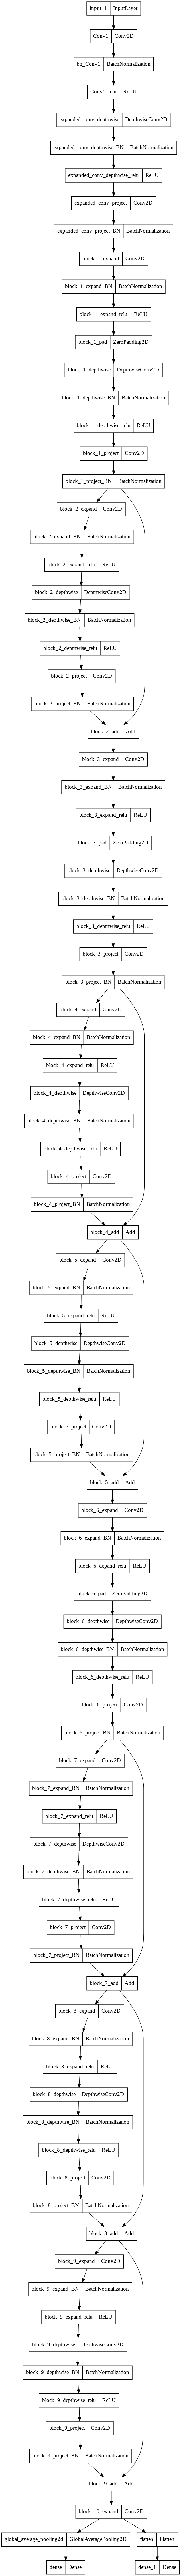

In [27]:
tf.keras.utils.plot_model(mn_cl_model)

In [26]:
history_mn_cl = mn_cl_model.fit(x_train, 
                          [y_train,y_bbox_train],  
                          epochs = 30, 
                          validation_data=(x_val,[y_val,y_bbox_val]),
                          #validation_split = 0.20, 
                          #class_weight = classWeight,
                          batch_size = 64,
                          callbacks = [checkpoint_cb, early_stopping_cb, lr_scheduler])

Epoch 1/30


InvalidArgumentError: ignored